The SIR model for disease

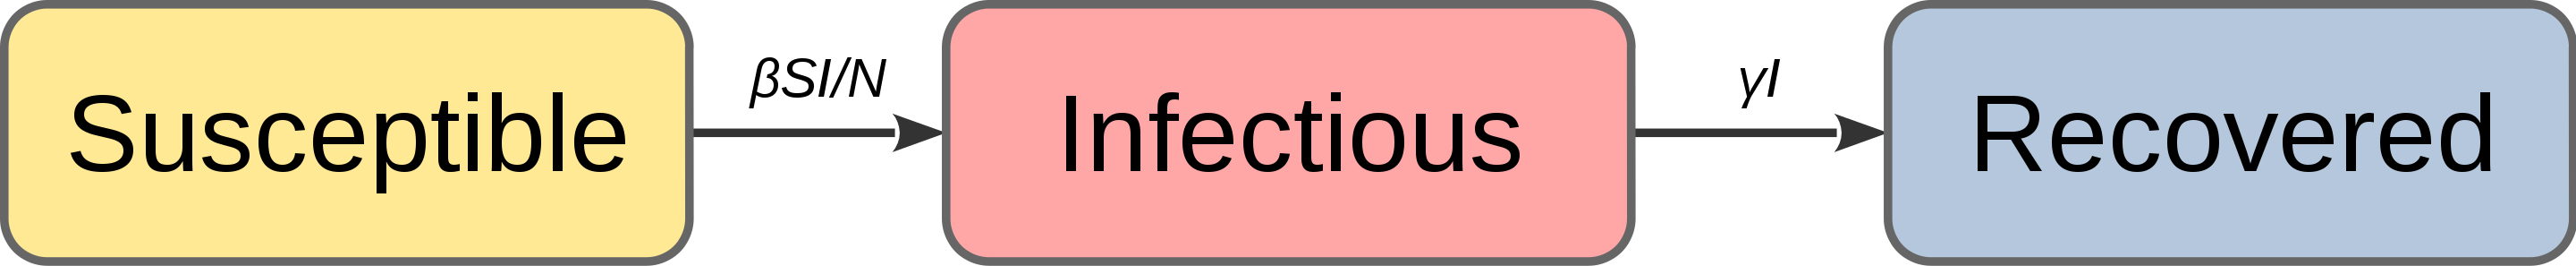

$$\begin{align}
\frac{\partial S}{\partial t} &= D_s \nabla^2 S -\beta \frac{S I}{N} \hspace{20mm}
\frac{\partial I}{\partial t} &= D_i \nabla^2 I + \beta \frac{S I}{N} - \gamma I \hspace{20mm}
\frac{\partial R}{\partial t} &= \gamma I.
\end{align}$$

Source: https://github.com/lukepolson/youtube_channel/blob/main/Python%20Metaphysics%20Series/vid2.ipynb

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

Let $A = (S, I, R)$. Need to define function that takes in $A$ and $t$ and returns $dA/dt = (dS/dt, dI/dt, dR/dt)$

**Parameters and Variables**

- $S$ : Susceptible individuals density (individuals/cm²)
- $I$ : Infectious individuals density (individuals/cm²)
- $R$ : Recovered individuals density (individuals/cm²)
- $\beta$ : Transmission rate (day⁻¹)
- $\gamma$ : Recovery rate (day⁻¹)
- $N$ : Total population
- $D_s$ : Diffusion coefficient for $S$ (cm²/day)
- $D_i$ : Diffusion coefficient for $I$ (cm²/day)

The Laplace Operator ∇^2
The Laplace operator, denoted as ∇^2 or Δ, is a mathematical tool indicating spatial coordinates. In the context of a spatial SIR model, it describes diffusive transmission—a process analogous to Brownian motion where a population or species spreads through a fluid medium. Mathematically, it is defined as the sum of all second-order spatial partial derivatives:
$$\nabla^2 u = \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} + \frac{\partial^2 u}{\partial z^2}$$


Numerical Approximation (Finite Differences)
Because most Partial Differential Equations (PDEs) of interest do not have analytical solutions, we use the Finite Difference Method (FDM) to find an approximation at discrete grid points. Following Taylor’s Theorem, the second spatial derivative is replaced by the "second-order symmetric difference" approximation:
$$\frac{\partial^2 u}{\partial x^2} \approx \frac{U_{i+1}^n - 2U_i^n + U_{i-1}^n}{\Delta x^2}$$
 
In our 2D code, this formula is extended to include the y-direction to account for both dimensions of the spatial grid

Periodic Boundary Conditions and np.roll()
To solve the equation at the edges of the grid, the code implements periodic boundary conditions. This treats the one-dimensional or two-dimensional space as if the ends are bound together to form a circle or ring.
The code utilizes np.roll() to handle the "ghost-values" required at the boundaries $$u_{-1} = u_N \text{ and } u_{N+1} = u_0$$
• np.roll(u, 1) represents the neighbor to the left $U_{i-1}^n$, as it shifts all values forward, bringing the last value to the first position.
• np.roll(u, -1) represents the neighbor to the right $U_{i+1}^n$, as it shifts values backward.
• By combining these in the symmetric difference formula, the code calculates the spatial curvature at every point in the grid simultaneously, allowing the simulation to model how the disease "diffuses" into neighboring areas over time

**Boundary Conditions?**

2. Do you need Neumann or Dirichlet Boundary Conditions?

In short: Only if you want to change how the "edges" of your world behave.

• Your current choice (Periodic): Your code uses np.roll, which implements Periodic Boundary Conditions. The sources explain that this treats your space as a circle or ring, where individuals exiting one side immediately re-enter from the other. This is described as "computationally very simple and unproblematic" because you do not have to take special care of derivatives at the boundary.

• When to use Dirichlet: You would implement this if you wanted the population at the borders to remain constant (e.g., the edge of the map always has zero infected individuals).

• When to use Neumann: You would implement this if you wanted to fix the rate of change at the boundary. A common use is u 
x=0, which represents a "no-flux" boundary where the concentration inside and outside the border is the same—effectively a wall that individuals cannot cross.

In [2]:
def dAdt(A, t, beta, gamma, N, Ds, Di, dx, dy, nx, ny):
    """
    Compute the time derivatives for the spatial SIR model using PDEs.
    
    This function calculates dS/dt, dI/dt, and dR/dt for all spatial grid points
    according to the reaction-diffusion equations:
    
    ∂S/∂t = D_s∇²S - β·S·I/N
    ∂I/∂t = D_i∇²I + β·S·I/N - γ·I
    ∂R/∂t = γ·I
    
    Parameters:
    -----------
    A : ndarray, shape (3*nx*ny,)
        Flattened 1D state vector containing [S_1, ..., S_n, I_1, ..., I_n, R_1, ..., R_n]
        where n = nx*ny is the total number of spatial grid points
    t : float
        Current time (required by odeint, but not used in this autonomous system)
    beta : float
        Transmission rate (day⁻¹) - controls infection spread
    gamma : float
        Recovery rate (day⁻¹) - controls transition from I to R
    N : float
        Total population (constant across all grid points)
    Ds : float
        Diffusion coefficient for susceptible population (cm²/day)
    Di : float
        Diffusion coefficient for infected population (cm²/day)
    dx : float
        Spatial grid spacing in x-direction (cm)
    dy : float
        Spatial grid spacing in y-direction (cm)
    nx : int
        Number of grid points in x-direction
    ny : int
        Number of grid points in y-direction
    
    Returns:
    --------
    ndarray, shape (3*nx*ny,)
        Flattened 1D array of time derivatives [dS/dt, dI/dt, dR/dt] for all grid points
    
    Notes:
    ------
    - Uses NEUMANN boundary conditions (zero-flux: ∂U/∂n = 0 at boundaries)
    - Physical meaning: No population enters or leaves the spatial domain
    - The Laplacian operator ∇² is approximated using central finite differences
    - Internal reshaping to 2D is done for spatial operations, then flattened for output
    """

    # =========================================================================
    # STEP 1: DETERMINE NUMBER OF SPATIAL GRID POINTS
    # =========================================================================
    n_points = len(A) // 3          # Total spatial points = nx * ny
                                     # Array A has 3 components (S, I, R)

    # =========================================================================
    # STEP 2: UNPACK AND RESHAPE 1D ARRAY INTO 2D SPATIAL GRIDS
    # =========================================================================
    # Extract each population component and reshape into 2D spatial grids
    # This allows us to apply spatial operators (Laplacian)
    S = A[0:n_points].reshape((nx, ny))              # Susceptible density grid
    I = A[n_points:2*n_points].reshape((nx, ny))     # Infected density grid
    R = A[2*n_points:3*n_points].reshape((nx, ny))   # Recovered density grid

    # =========================================================================
    # STEP 3: APPLY NEUMANN BOUNDARY CONDITIONS
    # =========================================================================
    # Neumann BC: ∂U/∂n = 0 (zero flux at boundaries)
    # Implementation: Copy edge values outward to enforce zero derivative
    # Physical meaning: No population crosses the boundaries
    #
    # Before computing Laplacian, we enforce BC by copying boundary values:
    #   - Top edge (row 0): copy from row 1
    #   - Bottom edge (row -1): copy from row -2
    #   - Left edge (col 0): copy from col 1
    #   - Right edge (col -1): copy from col -2
    #
    # This ensures that when we compute the Laplacian at boundary points,
    # the "ghost" values outside the domain equal the boundary values,
    # making ∂U/∂n = 0
    
    apply_neumann_bc(S)  # Apply zero-flux BC to S
    apply_neumann_bc(I)  # Apply zero-flux BC to I
    # Note: No need to apply BC to R since it has no diffusion term

    # =========================================================================
    # STEP 4: COMPUTE LAPLACIAN OPERATOR WITH NEUMANN BOUNDARY CONDITIONS
    # =========================================================================
    # The discrete Laplacian in 2D is:
    # ∇²U ≈ (U_{i+1,j} - 2U_{i,j} + U_{i-1,j})/Δx² + (U_{i,j+1} - 2U_{i,j} + U_{i,j-1})/Δy²
    #
    # laplacian_2d computes this using central finite differences
    # At boundaries, the BC enforcement ensures correct behavior
    
    laplace_S = laplacian_2d(S, dx, dy)  # Laplacian for Susceptible
    laplace_I = laplacian_2d(I, dx, dy)  # Laplacian for Infected

    # =========================================================================
    # STEP 5: COMPUTE TIME DERIVATIVES USING SIR EQUATIONS
    # =========================================================================
    # Susceptible equation: ∂S/∂t = D_s∇²S - β·S·I/N
    #   Term 1: D_s∇²S         → Spatial diffusion of susceptible individuals
    #   Term 2: -β·S·I/N       → Loss due to infection (S → I)
    dS = Ds * laplace_S - beta/N * S * I
    
    # Infected equation: ∂I/∂t = D_i∇²I + β·S·I/N - γ·I
    #   Term 1: D_i∇²I         → Spatial diffusion of infected individuals
    #   Term 2: +β·S·I/N       → Gain from new infections (S → I)
    #   Term 3: -γ·I           → Loss due to recovery (I → R)
    dI = Di * laplace_I + beta/N * S * I - gamma * I
    
    # Recovered equation: ∂R/∂t = γ·I
    #   Term 1: γ·I            → Gain from recovery (I → R)
    #   Note: No diffusion term for R in this model
    dR = gamma * I

    # =========================================================================
    # STEP 6: FLATTEN 2D GRIDS BACK TO 1D ARRAY FOR ODEINT
    # =========================================================================
    # odeint expects a 1D array output matching the 1D input format
    # Concatenate [dS, dI, dR] and flatten each 2D grid to 1D
    return np.concatenate([
        dS.ravel(),    # Flatten dS from (nx,ny) to (nx*ny,)
        dI.ravel(),    # Flatten dI from (nx,ny) to (nx*ny,)
        dR.ravel()     # Flatten dR from (nx,ny) to (nx*ny,)
    ])


def apply_neumann_bc(u: np.ndarray) -> None:
    """
    Apply zero-flux Neumann boundary conditions in-place.
    
    Implements ∂u/∂n = 0 at all boundaries by copying edge values.
    
    Physical interpretation:
    - No flux across boundaries (nothing enters or leaves)
    - Equivalent to impermeable walls
    
    Implementation:
    - Top boundary (row 0): u[0,:] = u[1,:]
    - Bottom boundary (row -1): u[-1,:] = u[-2,:]
    - Left boundary (col 0): u[:,0] = u[:,1]
    - Right boundary (col -1): u[:,-1] = u[:,-2]
    
    Parameters:
    -----------
    u : ndarray, shape (nx, ny)
        2D array to apply boundary conditions to (modified in-place)
    
    Returns:
    --------
    None (modifies u in-place)
    """
    u[0, :]  = u[1, :]      # Top edge: copy from row below
    u[-1, :] = u[-2, :]     # Bottom edge: copy from row above
    u[:, 0]  = u[:, 1]      # Left edge: copy from column to the right
    u[:, -1] = u[:, -2]     # Right edge: copy from column to the left


def laplacian_2d(u: np.ndarray, dx: float, dy: float) -> np.ndarray:
    """
    Compute 2D Laplacian using second-order central finite differences.
    
    Formula at interior points (i,j):
    ∇²u ≈ [u(i+1,j) - 2u(i,j) + u(i-1,j)]/Δx²
        + [u(i,j+1) - 2u(i,j) + u(i,j-1)]/Δy²
    
    At boundary points, the Laplacian is set to zero (will be correct after
    applying Neumann BC via apply_neumann_bc).
    
    Parameters:
    -----------
    u : ndarray, shape (nx, ny)
        2D array representing a scalar field
    dx : float
        Grid spacing in x-direction (cm)
    dy : float
        Grid spacing in y-direction (cm)
    
    Returns:
    --------
    lap : ndarray, shape (nx, ny)
        2D Laplacian of u at all grid points
        - Interior points: computed via finite differences
        - Boundary points: set to 0 (placeholder, BC applied separately)
    
    Notes:
    ------
    This function should be called AFTER applying boundary conditions
    via apply_neumann_bc() to ensure correct behavior at boundaries.
    """
    lap = np.zeros_like(u)
    
    # Compute Laplacian only at interior points (excluding boundaries)
    # Boundaries are handled separately via BC enforcement
    lap[1:-1, 1:-1] = (
        (u[1:-1, 2:] - 2*u[1:-1, 1:-1] + u[1:-1, :-2]) / dx**2 +   # x-direction
        (u[2:, 1:-1] - 2*u[1:-1, 1:-1] + u[:-2, 1:-1]) / dy**2     # y-direction
    )
    
    return lap

**Typical Parameter Values**

- $D_s = 0.01 - 0.1$ cm²/day
- $D_i = 0.01 - 0.1$ cm²/day
- $\beta = 0.1 - 0.5$ day⁻¹
- $\gamma = 0.05 - 0.2$ day⁻¹
- $N = 1000 - 5000$ (total population)

In [3]:
# =============================================================================
# SIMULATION PARAMETERS AND GRID CONFIGURATION
# =============================================================================

# -----------------------------------------------------------------------------
# Time discretization
# -----------------------------------------------------------------------------
# Define the time points at which to evaluate the solution
# times = [0, 1, 2, ..., 99] days
times = np.arange(0, 100, 0.00001)  # Start=0, Stop=100, Step=1 (day)
                               # Total simulation duration: 100 days
                               # Output frequency: every 1 day

# -----------------------------------------------------------------------------
# Epidemiological model parameters
# -----------------------------------------------------------------------------
# These parameters control the disease dynamics according to the SIR model:
# ∂S/∂t = D_s∇²S - β·S·I/N
# ∂I/∂t = D_i∇²I + β·S·I/N - γ·I
# ∂R/∂t = γ·I

gamma = 0.05    # Recovery rate (day⁻¹)
                # Physical meaning: 1/gamma = average infectious period
                # gamma = 0.05 → average infectious period = 20 days
                # Typical range: 0.05 - 0.2 day⁻¹

beta = 0.5      # Transmission rate (day⁻¹)
                # Controls how quickly infection spreads from I to S
                # Higher beta → faster disease spread
                # Typical range: 0.1 - 0.5 day⁻¹
                # Basic reproduction number: R₀ = β/γ = 0.5/0.05 = 10.0
                # R₀ > 1 indicates epidemic will occur

N = 5000        # Total population (constant)
                # Used as scaling factor in infection term β·S·I/N
                # Typical range: 1000 - 5000
                # Note: In spatial models, this is the total population
                # distributed across all grid points

# -----------------------------------------------------------------------------
# Spatial diffusion parameters
# -----------------------------------------------------------------------------
# Control how populations move/spread across the spatial domain

Ds = 0.1        # Diffusion coefficient for Susceptible population (cm²/day)
                # Controls spatial mobility of susceptible individuals
                # Lower value → less movement, more localized
                # Typical range: 0.01 - 0.1 cm²/day

Di = 0.01        # Diffusion coefficient for Infected population (cm²/day)
                # Controls spatial mobility of infected individuals
                # Di > Ds means infected individuals move more
                # This can represent behavioral changes or active spread
                # Typical range: 0.01 - 0.1 cm²/day

# -----------------------------------------------------------------------------
# Spatial grid discretization
# -----------------------------------------------------------------------------
# Define the computational grid for solving the spatial PDEs

dx = 1.0        # Grid spacing in x-direction (cm)
                # Distance between adjacent grid points horizontally
                # Smaller dx → finer spatial resolution, but more computation

dy = 1.0        # Grid spacing in y-direction (cm)
                # Distance between adjacent grid points vertically
                # For square grids: dx = dy is common

nx, ny = 10, 10 # Number of grid points in x and y directions
                # Creates a 10 × 10 = 100 spatial grid
                # Total spatial domain size:
                #   Width  = (nx-1) * dx = 9 cm
                #   Height = (ny-1) * dy = 9 cm
                #   Area   ≈ 81 cm²

n_points = nx * ny  # Total number of spatial grid points = 100
                    # Each of S, I, R will have 100 values (one per grid point)
                    # Total state vector size: 3 * n_points = 300

# =============================================================================
# GRID CONFIGURATION SUMMARY
# =============================================================================
# Spatial domain: 9 cm × 9 cm (approximately 81 cm²)
# Grid resolution: 10 × 10 = 100 points
# Grid spacing: 1.0 cm
# Total population: N = 5000 individuals distributed over 100 grid points
# Average density: 5000/100 = 50 individuals per grid point
#
# Stability consideration for explicit finite difference:
# Time step must satisfy: Δt ≤ min(dx²/(2D), dy²/(2D))
# For this configuration: Δt ≤ 1.0²/(2*0.1) = 5.0 days
# (odeint handles this automatically with adaptive time stepping)
# =============================================================================

In [4]:
# =============================================================================
# INITIAL CONDITIONS FOR THE SPATIAL SIR MODEL
# =============================================================================

# -----------------------------------------------------------------------------
# Initialize Susceptible population (S₀)
# -----------------------------------------------------------------------------
# Strategy: Distribute (N - 50) susceptible individuals uniformly across grid
# 
# Total susceptible: N - 50 = 5000 - 50 = 4950 individuals
# Per grid point: 4950 / 100 = 49.5 individuals/grid point
# 
# Creates a 10×10 array where each element = 49.5
S0 = np.ones((nx, ny)) * (N - 50) / n_points  # Shape: (10, 10)
                                               # All values: 49.5

# -----------------------------------------------------------------------------
# Initialize Infected population (I₀)
# -----------------------------------------------------------------------------
# Strategy: Start with zero infection everywhere, then add localized outbreak
#
# Step 1: Create empty grid (no infection anywhere)
I0 = np.zeros((nx, ny))  # Shape: (10, 10), all values = 0

# Step 2: Create a small localized "outbreak" at the center of the spatial domain
# This represents the initial infection source (e.g., patient zero's location)
#
# Center grid point indices:
#   i_center = nx//2 = 10//2 = 5
#   j_center = ny//2 = 10//2 = 5
#
# Infected region: A 2×2 square centered at (5,5)
#   Rows: [nx//2-1 : nx//2+1] = [4:6] → indices 4, 5
#   Cols: [ny//2-1 : ny//2+1] = [4:6] → indices 4, 5
#   This creates a 2×2 block at positions: (4,4), (4,5), (5,4), (5,5)
#
# Total infected: 50 individuals distributed over 4 grid points
# Per infected grid point: 50 / 4 = 12.5 individuals/grid point
I0[nx//2-1:nx//2+1, ny//2-1:ny//2+1] = 200 / 4  # 2×2 center block = 12.5 each

# -----------------------------------------------------------------------------
# Initialize Recovered population (R₀)
# -----------------------------------------------------------------------------
# Strategy: No recovered individuals at start of simulation
# Everyone starts as either Susceptible (4950) or Infected (50)
R0 = np.zeros((nx, ny))  # Shape: (10, 10), all values = 0

# -----------------------------------------------------------------------------
# Flatten 2D grids into 1D state vector for odeint
# -----------------------------------------------------------------------------
# odeint requires a 1D array as initial condition
# We concatenate the three 2D grids (S, I, R) into a single 1D vector
#
# Structure of y0:
#   y0 = [S₀(0,0), S₀(0,1), ..., S₀(9,9),    ← First 100 elements: S
#         I₀(0,0), I₀(0,1), ..., I₀(9,9),    ← Next 100 elements: I
#         R₀(0,0), R₀(0,1), ..., R₀(9,9)]    ← Last 100 elements: R
#
# Total length: 3 * nx * ny = 3 * 100 = 300 elements
y0 = np.concatenate([
    S0.ravel(),    # Flatten S0 from (10,10) to (100,) 
    I0.ravel(),    # Flatten I0 from (10,10) to (100,)
    R0.ravel()     # Flatten R0 from (10,10) to (100,)
])                 # Final shape: (300,)

# =============================================================================
# INITIAL CONDITION SUMMARY
# =============================================================================
# Total population: N = 5000
#   - Susceptible: 4950 (99.0%) - uniformly distributed
#   - Infected:      50 (1.0%)  - localized at center (2×2 block)
#   - Recovered:      0 (0.0%)  - none at start
#
# Spatial distribution:
#   - Most grid points: S=49.5, I=0.0, R=0.0
#   - Center 4 points:  S=49.5, I=12.5, R=0.0
#
# Conservation check:
#   Sum(S0) + Sum(I0) + Sum(R0) = 4950 + 50 + 0 = 5000 ✓
# =============================================================================

In [5]:
# =============================================================================
# SOLVE THE SPATIAL SIR MODEL USING ODEINT
# =============================================================================
# Use scipy's odeint (Ordinary Differential Equation integrator) to solve
# the system of coupled PDEs numerically over time.
#
# odeint uses adaptive time-stepping with the LSODA algorithm, which
# automatically switches between stiff and non-stiff integration methods
# for optimal performance.
# =============================================================================

sol = odeint(
    func=dAdt,      # Function: dAdt(A, t, ...) computes time derivatives
                    #   Input:  A (state vector), t (time)
                    #   Output: dA/dt (derivatives)
                    #   This function encodes the spatial SIR PDEs:
                    #     ∂S/∂t = D_s∇²S - β·S·I/N
                    #     ∂I/∂t = D_i∇²I + β·S·I/N - γ·I
                    #     ∂R/∂t = γ·I
    
    y0=y0,          # Initial condition: 1D array of shape (300,)
                    #   Contains [S₀, I₀, R₀] flattened from 2D grids
                    #   Initial state at t=0 days
                    #   Total: 100 S values + 100 I values + 100 R values
    
    t=times,        # Time points: array [0, 1, 2, ..., 99] days
                    #   odeint will return solution at these specific times
                    #   Length: 100 time points
                    #   odeint interpolates to these times from internal steps
    
    args=(beta, gamma, N, Ds, Di, dx, dy, nx, ny)
                    # Additional arguments passed to dAdt function:
                    #   beta  = 0.5     - Transmission rate (day⁻¹)
                    #   gamma = 0.05    - Recovery rate (day⁻¹)
                    #   N     = 5000    - Total population (constant)
                    #   Ds    = 0.01    - Susceptible diffusion (cm²/day)
                    #   Di    = 0.1     - Infected diffusion (cm²/day)
                    #   dx    = 1.0     - Grid spacing in x-direction (cm)
                    #   dy    = 1.0     - Grid spacing in y-direction (cm)
                    #   nx    = 10      - Number of grid points in x
                    #   ny    = 10      - Number of grid points in y
)

# =============================================================================
# OUTPUT STRUCTURE OF 'sol'
# =============================================================================
# sol is a 2D numpy array with shape (n_times, n_states) = (100, 300)
#
# Dimensions:
#   - Rows (axis 0): Time points [0, 1, 2, ..., 99] days
#   - Columns (axis 1): State variables at all spatial grid points
#
# Column layout:
#   - Columns 0-99:     S values at all 100 grid points (flattened)
#   - Columns 100-199:  I values at all 100 grid points (flattened)
#   - Columns 200-299:  R values at all 100 grid points (flattened)
#
# Interpretation:
#   sol[t, :] → Complete state vector at time index t
#   sol[t, 0:100] → All S values at time t (needs reshape to (10,10) for 2D)
#   sol[t, 100:200] → All I values at time t
#   sol[t, 200:300] → All R values at time t
#
# To visualize spatially: extract column range and reshape to (nx, ny)
# To analyze temporally: extract row to see evolution at specific time
#
# Memory: 100 times × 300 variables × 8 bytes = 240 KB
# =============================================================================

# =============================================================================
# NUMERICAL INTEGRATION METHOD: LSODA
# =============================================================================
# Algorithm: Livermore Solver for Ordinary Differential equations with 
#            Automatic method switching
#
# Features:
#   - Adaptive time-stepping: automatically adjusts internal step size
#     based on solution behavior (may use steps much smaller than 1 day)
#   - Automatic stiffness detection: switches between non-stiff (Adams)
#     and stiff (BDF) methods as needed
#   - Interpolation: computes solution at requested 'times' from internal
#     integration steps
#
# Why adaptive stepping matters:
#   - Early in epidemic: rapid changes → small steps needed
#   - Late in epidemic: slow changes → larger steps possible
#   - Saves computation while maintaining accuracy
#
# Error control:
#   - Uses relative and absolute tolerances to control accuracy
#   - Default: rtol=1.49e-8, atol=1.49e-8 (very high accuracy)
#   - Solution guaranteed to satisfy: error < atol + rtol*|y|
# =============================================================================

In [6]:
# =============================================================================
# VERIFY OUTPUT DIMENSIONS OF THE SOLUTION ARRAY
# =============================================================================
# This expression checks that odeint returned the expected array shape.
# Returns True if dimensions are correct, False otherwise.
#
# Expected shape: (n_time_points, n_state_variables)
#               = (100, 300)
#
# Breakdown:
#   - First dimension (rows): len(times) = 100
#     → Number of time points where solution was evaluated
#     → Corresponds to t = [0, 1, 2, ..., 99] days
#
#   - Second dimension (columns): 3 * nx * ny = 3 * 10 * 10 = 300
#     → Total number of state variables across all grid points
#     → Factor of 3: S, I, and R populations
#     → nx * ny = 100: number of spatial grid points
#     → Total: 100 S values + 100 I values + 100 R values = 300
#
# Why this check is important:
#   - Confirms odeint successfully integrated the system
#   - Ensures subsequent indexing operations won't fail
#   - Verifies that all spatial points and populations are present
#
# If False, possible issues:
#   - Integration failed or stopped prematurely
#   - Incorrect parameters passed to odeint
#   - Memory allocation problems
#
# Typical usage: This is often used in an assert statement for validation
sol.shape == (len(times), 3 * nx * ny)


True


# INTERPRETATION OF VISUALIZATION

 The resulting plot shows:
   - X-axis: spatial grid in x-direction (0-9)
   - Y-axis: spatial grid in y-direction (0-9)
   - Colors: infected population density at each grid point
     - Darker colors (typically blue/purple): low infection
     - Brighter colors (typically red/yellow): high infection
   - Pattern: Shows spatial spread of disease from initial center outbreak

 At day 20, you can observe:
   - How far infection has diffused from center (5,5)
   - Concentration gradients (center vs periphery)
   - Effectiveness of spatial containment


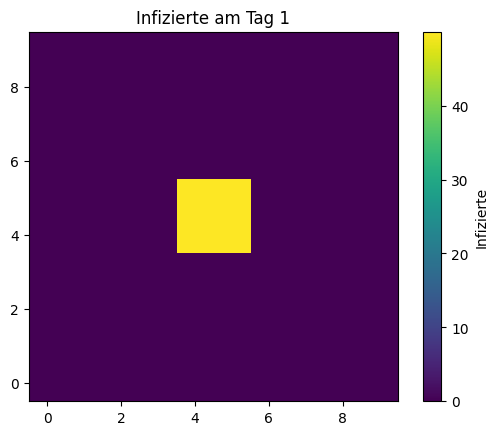

In [7]:
time_idx = 1
n = nx * ny

I_solution = sol[:, n:2*n]
I_2D = I_solution[time_idx].reshape((nx, ny))

plt.imshow(I_2D, origin='lower')
plt.colorbar(label="Infizierte")
plt.title(f"Infizierte am Tag {time_idx}")
plt.show()


In [ ]:
time_idx = 50
n = nx * ny

# Extract solutions for all compartments
S_solution = sol[:, 0:n]
I_solution = sol[:, n:2*n]
R_solution = sol[:, 2*n:3*n]

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Spatial distribution at specific time
I_2D = I_solution[time_idx].reshape((nx, ny))
im = ax1.imshow(I_2D, origin='lower')
plt.colorbar(im, ax=ax1, label="Infizierte")
ax1.set_title(f"Infizierte am Tag {time_idx}")

# Right plot: Time series of total populations

plt.plot(times, S_solution)
plt.plot(times, I_solution)
plt.plot(times, R_solution)
plt.grid()

plt.tight_layout()
plt.show()

In [10]:
import plotly.graph_objects as go

# Define ranges for diffusion coefficients
Ds_range = np.linspace(0.01, 0.1, 20)
Di_range = np.linspace(0.01, 0.1, 20)

# Create meshgrid for Ds and Di
Ds_grid, Di_grid = np.meshgrid(Ds_range, Di_range)

# Select time point to analyze
time_idx = 50
n = nx * ny

# Initialize result array for peak infected values
Z = np.zeros_like(Ds_grid)

# Run simulation for each combination of Ds and Di
for i in range(len(Di_range)):
    for j in range(len(Ds_range)):
        # Run simulation with current Ds, Di values
        sol_temp = odeint(
            dAdt,
            y0,
            times,
            args=(beta, gamma, N, Ds_range[j], Di_range[i], dx, dy, nx, ny)
        )
        
        # Extract infected at time_idx and get maximum value
        I_temp = sol_temp[time_idx, n:2*n]
        Z[i, j] = I_temp.max()

# Create 3D surface plot
fig = go.Figure(data=[go.Surface(
    z=Z,
    x=Ds_grid,
    y=Di_grid,
    colorscale='Viridis',
    opacity=0.9,
    showscale=True
)])

# Set axis titles
fig.update_layout(
    title=f"Maximale Infizierte vs. Diffusionskoeffizienten (Tag {time_idx})",
    scene=dict(
        xaxis_title="Ds (cm²/day)",
        yaxis_title="Di (cm²/day)",
        zaxis_title="Max. Infizierte",
    ),
    width=900,
    height=700,
    margin=dict(l=50, r=50, b=50, t=100)
)

fig.show()

KeyboardInterrupt: 

Use real data

